In [16]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
# train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
# train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)

train_df = train_df.drop(columns='wc_decimal_count')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def bootstap_conf(bins, n, confidence_level, num_bootstrap_samples=1000):    
    boot_means = np.zeros((num_bootstrap_samples, len(bins) - 1))

    for i in range(num_bootstrap_samples):
        sample = train_df['price'].sample(n, replace=True)  # Bootstrap resampling
        boot_means[i], _ = np.histogram(sample, bins=bins)

    # Compute mean, lower, and upper confidence bounds
    hist_mean = np.mean(boot_means, axis=0)
    lower_bound = np.percentile(boot_means, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bound = np.percentile(boot_means, (1 + confidence_level) / 2 * 100, axis=0)
    return hist_mean, lower_bound, upper_bound

brand 80.87274884286451
count: 9705


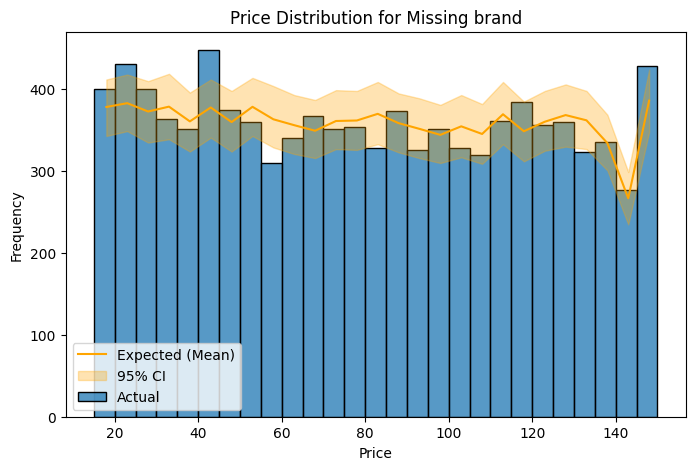

material 81.63762580687671
count: 8347


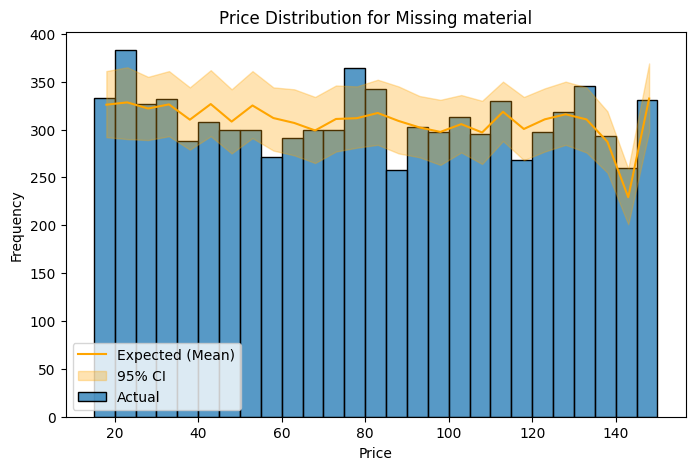

size 78.67119002577711
count: 6595


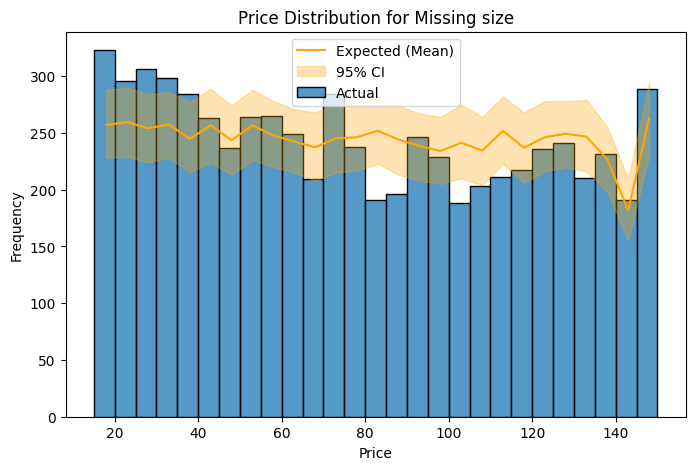

laptop_compartment 79.32189522031166
count: 7444


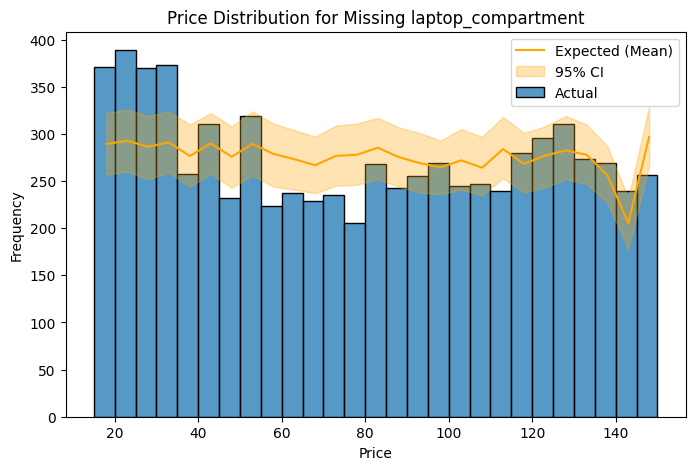

is_waterproof 78.2638234680851
count: 7050


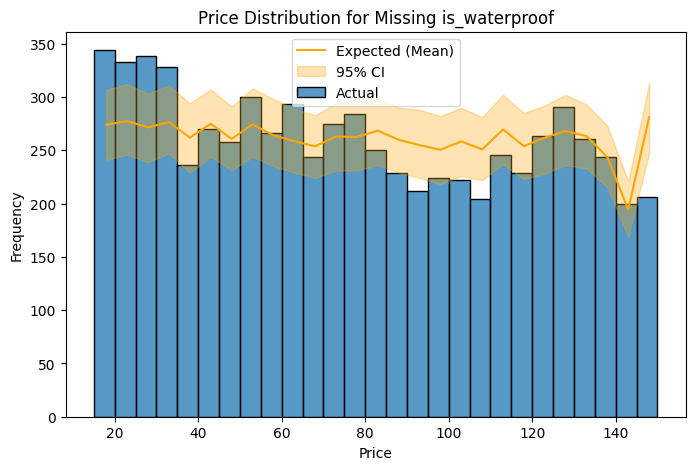

style 81.9584300941029
count: 7970


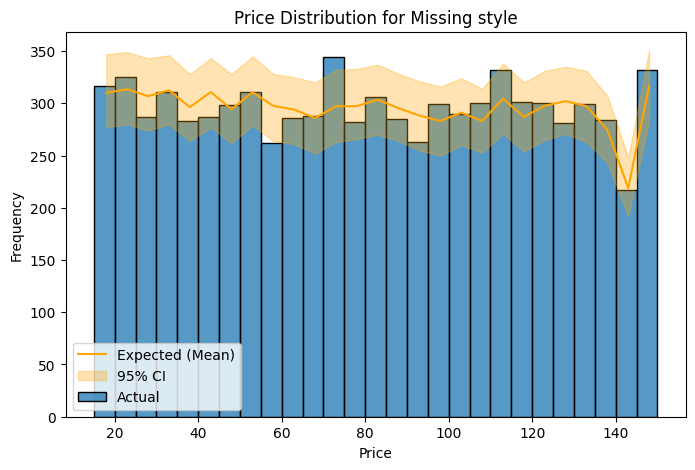

color 81.7713290241206
count: 9950


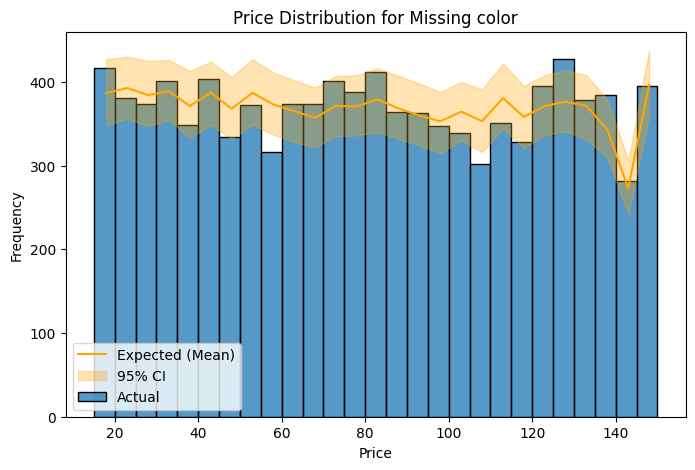

weight_capacity 62.660328623188406
count: 138


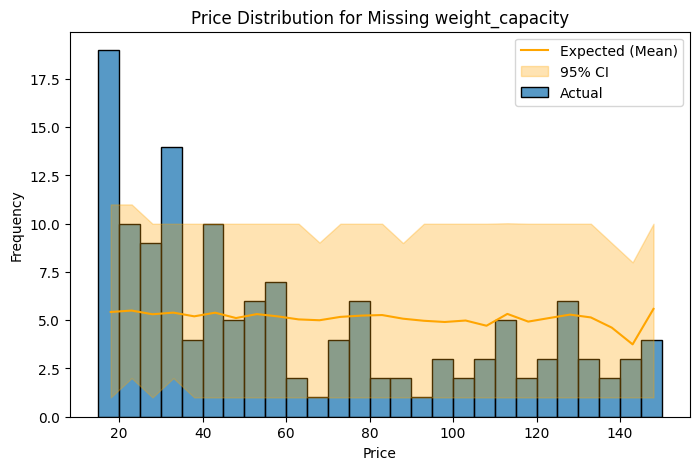

In [65]:
binwidth = 5  # Adjust based on your data range
bins = range(int(train_df['price'].min()), int(train_df['price'].max()) + binwidth, binwidth)
confidence_level = 0.95

for col in ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color', 'weight_capacity']:
    missing_val = train_df[(train_df[col] == -1)]
    
    # Compute statistics
    print(col, missing_val['price'].mean())
    n = len(missing_val['price'])
    print("count:", n)
    
    # Set bin width dynamically for better alignment

    # Plot aligned histograms
    plt.figure(figsize=(8, 5))
    sns.histplot(missing_val['price'], bins=bins, label='Actual', kde=False)
    # Plot Confidence Interval as a shaded region
    hist_mean, lower_bound, upper_bound = bootstap_conf(bins, n, confidence_level)
    bin_centers = [i - (binwidth//2) for i in bins if i != 15]
    plt.plot(bin_centers, hist_mean, label="Expected (Mean)", color="orange")
    plt.fill_between(bin_centers, lower_bound, upper_bound, color='orange', alpha=0.3, label=f"{int(confidence_level*100)}% CI")

    # Add labels and legend
    plt.legend()
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.title(f"Price Distribution for Missing {col}")
    plt.show()

In [69]:
from sklearn.neighbors import KernelDensity

# Fit KDE to the target variable where the feature is missing (-1)
kde = KernelDensity(bandwidth=15, kernel='gaussian')
kde.fit(missing_val['price'].values.reshape(-1, 1))

# Encode as probability density at different points
# train_df.loc[train_df[col] == -1, f'{col}_prob_encoded'] = 
# kde.score_samples(train_df['price'].values.reshape(-1, 1))
kde.score_samples(train_df.iloc[:5]['price'].values.reshape(-1, 1))


array([-5.40717435, -5.16671751, -4.50014914, -5.39413164, -5.46707909])

In [67]:
train_df.iloc[:5]

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price
0,3,0,1,7,1,0,2,0,11.611723,112.15875
1,3,3,0,10,1,1,1,4,27.078537,68.88056
2,4,0,0,2,1,0,1,2,16.643760,39.17320
3,2,1,0,8,1,0,1,4,12.937220,80.60793
4,0,3,1,1,1,1,1,4,17.749338,86.02312


78.55144184935357


<Axes: xlabel='price', ylabel='Count'>

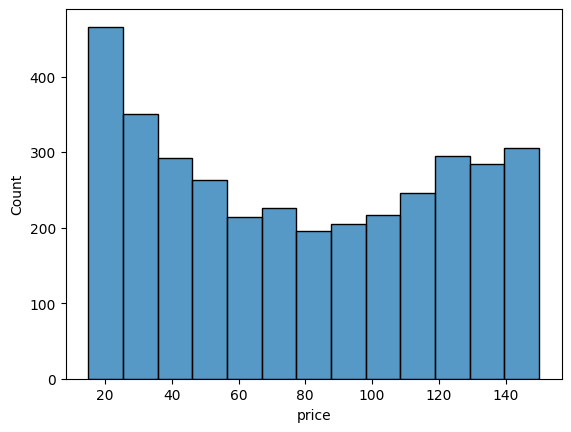

In [32]:
rows_with_multiple_neg_ones = train_df[(train_df == -1).sum(axis=1) > 1]

print(rows_with_multiple_neg_ones['price'].mean())
sns.histplot(rows_with_multiple_neg_ones['price'])

<Axes: xlabel='price', ylabel='Count'>

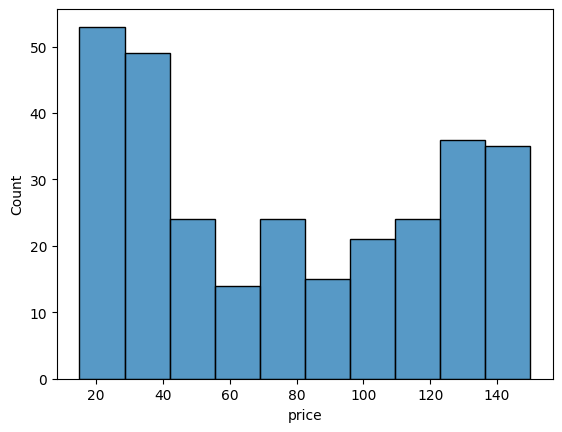

In [30]:
train_df[(train_df == -1).sum(axis=1) > 2]['price'].mean()
sns.histplot(train_df[(train_df == -1).sum(axis=1) > 2]['price'])

<Axes: xlabel='price', ylabel='Count'>

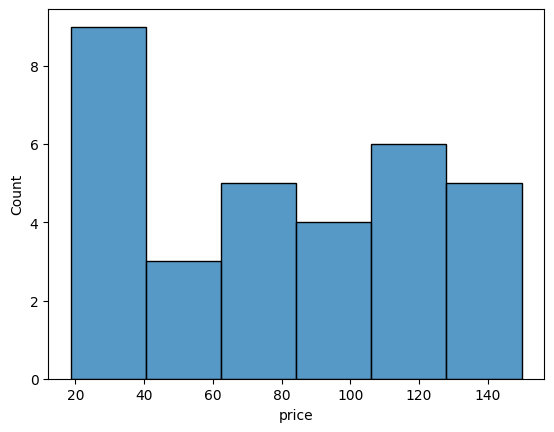

In [31]:
train_df[(train_df == -1).sum(axis=1) > 3]['price'].mean()
sns.histplot(train_df[(train_df == -1).sum(axis=1) > 3]['price'])

In [146]:
import itertools

# ----------------------------------------------------
# 1. Make a function that, given the population prices
#    and a sample size n, returns the bootstrap CI.
# ----------------------------------------------------
def population_bootstrap_ci(population_prices, n, num_bootstrap_samples=1000, confidence_level=0.95):
    """
    Computes the bootstrap confidence interval by drawing samples of size n
    from the entire population of prices. This CI represents what the
    'typical' mean would be if we randomly picked n items from the population.
    """
    # If sample size < 2 or if there's no real population, just return NaNs
    if n < 2:
        return np.nan, np.nan

    boot_means = []
    for _ in range(num_bootstrap_samples):
        sample = np.random.choice(population_prices, size=n, replace=True)
        boot_means.append(sample.mean())

    lower_bound = np.percentile(boot_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(boot_means, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound

# ----------------------------------------------------
# 2. Cache to avoid recomputing the above for each group
#    of the same size.
# ----------------------------------------------------
def get_population_ci_for_size(population_prices, group_size, cache_dict, 
                               num_bootstrap_samples=1000, confidence_level=0.95):
    """
    Wrapper that checks if we've already computed the population CI
    for the given group_size. If not, compute and store in cache.
    """
    if group_size in cache_dict:
        return cache_dict[group_size]
    else:
        ci = population_bootstrap_ci(
            population_prices, 
            n=group_size,
            num_bootstrap_samples=num_bootstrap_samples,
            confidence_level=confidence_level
        )
        cache_dict[group_size] = ci
        return ci

# ----------------------------------------------------
# 3. Main logic: For each pair of columns, group and test.
# ----------------------------------------------------
def find_significant_deviations(train_df, cols,
                                num_bootstrap_samples=1000,
                                confidence_level=0.95):
    """
    For each combination of columns in `cols`, compute the group mean
    and compare it against the population-based bootstrap confidence interval
    (with sample size matching the group's size).
    """
    # Extract the entire population of prices (as a NumPy array).
    population_prices = train_df['price'].values

    # A dict to store results for each (col1, col2) pair.
    results_outside_ci = {}

    # We'll use this dictionary to memoize (cache) population CIs by group size
    ci_cache = {}

    # Iterate over all pairs of columns
    for col1, col2 in itertools.combinations(cols, 2):
        combined_col_name = f"{col1}_{col2}"

        # Create a combined column
        train_df[combined_col_name] = (
            train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
        )

        # Group by this new combined column to compute count and mean
        grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()

        # For each group, compute the population-based CI and check if mean is out of it
        # We'll add columns for the CI and a flag for "is_outside"
        ci_results = []
        is_outside_list = []

        for idx, row in grouped.iterrows():
            group_size = row['count'] // 100 * 100 # Round to the nearest 100
            group_mean = row['mean']

            # Get the population-based CI for this group size
            low_ci, high_ci = get_population_ci_for_size(
                population_prices, 
                group_size, 
                ci_cache, 
                num_bootstrap_samples=num_bootstrap_samples, 
                confidence_level=confidence_level
            )

            ci_results.append((low_ci, high_ci))
            # Check if group_mean is outside the population-based CI for that size
            is_outside = (group_mean < low_ci) or (group_mean > high_ci)
            is_outside_list.append(is_outside)

        # Convert the CI results into columns
        grouped['low_ci'] = [r[0] for r in ci_results]
        grouped['high_ci'] = [r[1] for r in ci_results]
        grouped['is_outside_ci'] = is_outside_list

        # Now filter only the groups that are outside the confidence interval
        outliers = grouped[grouped['is_outside_ci']]

        # Store the outlier dataframe in the dictionary
        results_outside_ci[combined_col_name] = outliers

        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{outliers['count'].sum() / grouped['count'].sum():.2%}: {combined_col_name}")

        # Remove the combined column from train_df
        train_df.drop(columns=[combined_col_name], inplace=True)

    return results_outside_ci

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']

results = find_significant_deviations(train_df, cols, num_bootstrap_samples=1000, confidence_level=0.95)

summary = []
for k, v in results.items():
    summary.append((v['count'].sum() / n, k))
summary.sort(reverse=True)
for i in range(10):
    print(f"{summary[i][0]:.0%}: {summary[i][1]}")

85%: material_is_waterproof
76%: material_laptop_compartment
64%: material_style
63%: style_color
63%: is_waterproof_color
57%: material_size
57%: brand_material
55%: laptop_compartment_color
54%: size_color
50%: brand_is_waterproof


In [ ]:
n = len(train_df)

In [142]:
summary = []
for k, v in results.items():
    summary.append((v['count'].sum() / n, k))
summary.sort(reverse=True)
for i in range(5):
    print(f"{summary[i][0]:.0%}: {summary[i][1]}")

62%: material_laptop_compartment_is_waterproof
52%: material_laptop_compartment_style
47%: material_is_waterproof_style
47%: laptop_compartment_is_waterproof_color
46%: material_size_is_waterproof


61.72%: brand_material
76.34%: material_laptop_compartment
85.35%: material_is_waterproof
64.03%: material_style

In [113]:
results['material_is_waterproof']

,material_is_waterproof,count,mean,low_ci,high_ci,is_outside_ci
0,-1_-1,120,70.623429,73.641758,88.546772,True
3,0_-1,1647,75.955542,79.631774,83.267177,True
4,0_0,35422,80.415539,81.003137,81.806290,True
5,0_1,36347,80.662768,81.001911,81.805656,True
6,1_-1,1638,78.138102,79.631774,83.267177,True
8,1_1,34866,80.858112,80.993595,81.817574,True
9,2_-1,2028,78.903181,79.605492,83.227574,True
10,2_0,38379,82.197000,81.017938,81.771958,True
11,2_1,39223,82.034993,81.027706,81.818402,True
13,3_0,32897,82.274548,80.998593,81.835873,True


In [112]:
results['material_is_waterproof']

# 76%
results['material_laptop_compartment']

,material_laptop_compartment,count,mean,low_ci,high_ci,is_outside_ci
1,-1_0,4004,83.385643,80.176638,82.562769,True
2,-1_1,4205,80.166477,80.221799,82.494549,True
3,0_-1,1792,78.896039,79.631076,83.244852,True
4,0_0,35432,80.413702,81.003137,81.806290,True
5,0_1,36192,80.537899,81.018238,81.823622,True
6,1_-1,1826,78.746859,79.606708,83.099116,True
10,2_0,37972,81.918746,81.006012,81.779508,True
11,2_1,39581,82.237133,81.045228,81.816197,True
12,3_-1,1611,79.565073,79.631774,83.267177,True
13,3_0,32926,82.181252,80.964236,81.849824,True


In [143]:
def find_significant_deviations_of_three(
        train_df, cols,
        num_bootstrap_samples=1000,
        confidence_level=0.95
    ):
    """
    For each combination of three columns in `cols`, compute the group mean
    and compare it against the population-based bootstrap confidence interval
    (with sample size matching the group's size).
    """
    # Extract the entire population of prices (as a NumPy array).
    population_prices = train_df['price'].values

    # A dict to store results for each (col1, col2, col3) combination.
    results_outside_ci = {}

    # We'll use this dictionary to memoize (cache) population CIs by group size.
    ci_cache = {}

    # Iterate over all combinations of three columns
    for col1, col2, col3 in itertools.combinations(cols, 3):
        combined_col_name = f"{col1}_{col2}_{col3}"

        # Create a combined column by concatenating the string values of the three columns.
        train_df[combined_col_name] = (
            train_df[col1].astype(str) + "_" +
            train_df[col2].astype(str) + "_" +
            train_df[col3].astype(str)
        )

        # Group by this new combined column to compute count and mean.
        grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()

        # For each group, compute the population-based CI and check if the mean is out of it.
        ci_results = []
        is_outside_list = []

        for idx, row in grouped.iterrows():
            group_size = row['count'] // 100 * 100  # Round to the nearest 100.
            group_mean = row['mean']

            # Get the population-based CI for this group size.
            low_ci, high_ci = get_population_ci_for_size(
                population_prices, 
                group_size, 
                ci_cache, 
                num_bootstrap_samples=num_bootstrap_samples, 
                confidence_level=confidence_level
            )

            ci_results.append((low_ci, high_ci))
            # Check if group_mean is outside the population-based CI for that size.
            is_outside = (group_mean < low_ci) or (group_mean > high_ci)
            is_outside_list.append(is_outside)

        # Convert the CI results into columns.
        grouped['low_ci'] = [r[0] for r in ci_results]
        grouped['high_ci'] = [r[1] for r in ci_results]
        grouped['is_outside_ci'] = is_outside_list

        # Now filter only the groups that are outside the confidence interval.
        outliers = grouped[grouped['is_outside_ci']]

        # Store the outlier dataframe in the dictionary.
        results_outside_ci[combined_col_name] = outliers

        # Print the percentage of counts that are outliers.
        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{outliers['count'].sum() / grouped['count'].sum():.2%}: {combined_col_name}")

        # Remove the combined column from train_df.
        train_df.drop(columns=[combined_col_name], inplace=True)

    return results_outside_ci

# List of columns to consider.
cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']

# Example usage:
results = find_significant_deviations_of_three(train_df, cols, num_bootstrap_samples=1000, confidence_level=0.95)
summary = []
for k, v in results.items():
    summary.append((v['count'].sum() / n, k))
summary.sort(reverse=True)
for i in range(10):
    print(f"{summary[i][0]:.0%}: {summary[i][1]}")

62%: material_laptop_compartment_is_waterproof
48%: material_laptop_compartment_style
47%: material_is_waterproof_style
46%: material_size_is_waterproof
43%: laptop_compartment_is_waterproof_color
41%: material_size_laptop_compartment
40%: brand_material_is_waterproof
37%: material_is_waterproof_color
35%: brand_laptop_compartment_is_waterproof
35%: material_size_style


45.22%: material_size_laptop_compartment
61.87%: material_laptop_compartment_is_waterproof
51.69%: material_laptop_compartment_style
47.43%: material_is_waterproof_style
45.80%: material_size_is_waterproof

In [151]:
# results['material_laptop_compartment_is_waterproof']

In [150]:
# results['material_is_waterproof_style']

In [147]:
def find_significant_deviations_of_four(
        train_df, cols,
        num_bootstrap_samples=1000,
        confidence_level=0.95
    ):
    """
    For each combination of three columns in `cols`, compute the group mean
    and compare it against the population-based bootstrap confidence interval
    (with sample size matching the group's size).
    """
    # Extract the entire population of prices (as a NumPy array).
    population_prices = train_df['price'].values

    # A dict to store results for each (col1, col2, col3) combination.
    results_outside_ci = {}

    # We'll use this dictionary to memoize (cache) population CIs by group size.
    ci_cache = {}

    # Iterate over all combinations of three columns
    for col1, col2, col3, col4 in itertools.combinations(cols, 4):
        combined_col_name = f"{col1}_{col2}_{col3}_{col4}"

        # Create a combined column by concatenating the string values of the three columns.
        train_df[combined_col_name] = (
            train_df[col1].astype(str) + "_" +
            train_df[col2].astype(str) + "_" +
            train_df[col3].astype(str) + "_" +
            train_df[col4].astype(str)
        )

        # Group by this new combined column to compute count and mean.
        grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()

        # For each group, compute the population-based CI and check if the mean is out of it.
        ci_results = []
        is_outside_list = []

        for idx, row in grouped.iterrows():
            group_size = row['count'] // 100 * 100  # Round to the nearest 100.
            group_mean = row['mean']

            # Get the population-based CI for this group size.
            low_ci, high_ci = get_population_ci_for_size(
                population_prices, 
                group_size, 
                ci_cache, 
                num_bootstrap_samples=num_bootstrap_samples, 
                confidence_level=confidence_level
            )

            ci_results.append((low_ci, high_ci))
            # Check if group_mean is outside the population-based CI for that size.
            is_outside = (group_mean < low_ci) or (group_mean > high_ci)
            is_outside_list.append(is_outside)

        # Convert the CI results into columns.
        grouped['low_ci'] = [r[0] for r in ci_results]
        grouped['high_ci'] = [r[1] for r in ci_results]
        grouped['is_outside_ci'] = is_outside_list

        # Now filter only the groups that are outside the confidence interval.
        outliers = grouped[grouped['is_outside_ci']]

        # Store the outlier dataframe in the dictionary.
        results_outside_ci[combined_col_name] = outliers

        # Print the percentage of counts that are outliers.
        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{outliers['count'].sum() / grouped['count'].sum():.2%}: {combined_col_name}")

        # Remove the combined column from train_df.
        train_df.drop(columns=[combined_col_name], inplace=True)

    return results_outside_ci

# List of columns to consider.
cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']

# Example usage:
results = find_significant_deviations_of_four(train_df, cols, num_bootstrap_samples=1000, confidence_level=0.95)

summary = []
for k, v in results.items():
    summary.append((v['count'].sum() / n, k))
summary.sort(reverse=True)
for i in range(10):
    print(f"{summary[i][0]:.0%}: {summary[i][1]}")

23%: brand_material_laptop_compartment_is_waterproof
23%: material_laptop_compartment_is_waterproof_color
22%: laptop_compartment_is_waterproof_style_color
22%: material_size_laptop_compartment_is_waterproof
21%: material_size_laptop_compartment_color
19%: size_laptop_compartment_is_waterproof_color
19%: material_laptop_compartment_is_waterproof_style
18%: material_size_is_waterproof_color
17%: material_size_is_waterproof_style
16%: brand_laptop_compartment_is_waterproof_color


* 23.92%: material_size_laptop_compartment_is_waterproof
* 18.74%: material_laptop_compartment_is_waterproof_style
* 22.73%: material_laptop_compartment_is_waterproof_color

In [148]:
def find_significant_deviations_of_five(
        train_df, cols,
        num_bootstrap_samples=1000,
        confidence_level=0.95
    ):
    """
    For each combination of three columns in `cols`, compute the group mean
    and compare it against the population-based bootstrap confidence interval
    (with sample size matching the group's size).
    """
    # Extract the entire population of prices (as a NumPy array).
    population_prices = train_df['price'].values

    # A dict to store results for each (col1, col2, col3) combination.
    results_outside_ci = {}

    # We'll use this dictionary to memoize (cache) population CIs by group size.
    ci_cache = {}

    # Iterate over all combinations of three columns
    for col1, col2, col3, col4, col5 in itertools.combinations(cols, 5):
        combined_col_name = f"{col1}_{col2}_{col3}_{col4}_{col5}"

        # Create a combined column by concatenating the string values of the three columns.
        train_df[combined_col_name] = (
            train_df[col1].astype(str) + "_" +
            train_df[col2].astype(str) + "_" +
            train_df[col3].astype(str) + "_" +
            train_df[col4].astype(str) + "_" +
            train_df[col5].astype(str)
        )

        # Group by this new combined column to compute count and mean.
        grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()

        # For each group, compute the population-based CI and check if the mean is out of it.
        ci_results = []
        is_outside_list = []

        for idx, row in grouped.iterrows():
            group_size = row['count'] // 100 * 100  # Round to the nearest 100.
            group_mean = row['mean']

            # Get the population-based CI for this group size.
            low_ci, high_ci = get_population_ci_for_size(
                population_prices, 
                group_size, 
                ci_cache, 
                num_bootstrap_samples=num_bootstrap_samples, 
                confidence_level=confidence_level
            )

            ci_results.append((low_ci, high_ci))
            # Check if group_mean is outside the population-based CI for that size.
            is_outside = (group_mean < low_ci) or (group_mean > high_ci)
            is_outside_list.append(is_outside)

        # Convert the CI results into columns.
        grouped['low_ci'] = [r[0] for r in ci_results]
        grouped['high_ci'] = [r[1] for r in ci_results]
        grouped['is_outside_ci'] = is_outside_list

        # Now filter only the groups that are outside the confidence interval.
        outliers = grouped[grouped['is_outside_ci']]

        # Store the outlier dataframe in the dictionary.
        results_outside_ci[combined_col_name] = outliers

        # Print the percentage of counts that are outliers.
        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{outliers['count'].sum() / grouped['count'].sum():.2%}: {combined_col_name}")

        # Remove the combined column from train_df.
        train_df.drop(columns=[combined_col_name], inplace=True)

    return results_outside_ci

# List of columns to consider.
cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']

# Example usage:
results = find_significant_deviations_of_five(train_df, cols, num_bootstrap_samples=1000, confidence_level=0.95)

summary = []
for k, v in results.items():
    summary.append((v['count'].sum() / n, k))
summary.sort(reverse=True)
for i in range(10):
    print(f"{summary[i][0]:.0%}: {summary[i][1]}")

11%: material_laptop_compartment_is_waterproof_style_color
10%: material_size_laptop_compartment_is_waterproof_color
10%: material_size_laptop_compartment_is_waterproof_style
8%: size_laptop_compartment_is_waterproof_style_color
8%: brand_material_laptop_compartment_is_waterproof_style
8%: brand_material_laptop_compartment_is_waterproof_color
7%: material_size_laptop_compartment_style_color
7%: brand_size_laptop_compartment_is_waterproof_style
7%: material_size_is_waterproof_style_color
7%: brand_material_size_laptop_compartment_is_waterproof


* 10.74%: material_size_laptop_compartment_is_waterproof_style
* 10.20%: material_laptop_compartment_is_waterproof_style_color

In [149]:
# results['material_laptop_compartment_is_waterproof_style_color']

In [169]:
def te_cv(combined_col_name, train_df):
    kf = KFold(n_splits=10, shuffle=True, random_state=4444)
    rmse_list = []
    for train_index, val_index in kf.split(train_df):
        train_fold = train_df.iloc[train_index]
        val_fold = train_df.iloc[val_index]

        te = TargetEncoder(target_type="continuous", smooth=2)
        # te = TargetEncoder(target_type="continuous", smooth=20)
        train_fold['te'] = (
            te.fit_transform(train_fold[[combined_col_name]], train_fold[target])
        )
        val_fold['te'] = (
            te.transform(val_fold[[combined_col_name]])
        )
        rmse = root_mean_squared_error(val_fold[target], val_fold['te'])
        rmse_list.append(rmse)
    return np.mean(rmse_list)

def find_significant_deviations(train_df, cols,
                                num_bootstrap_samples=1000,
                                confidence_level=0.95):
    """
    For each combination of columns in `cols`, compute the group mean
    and compare it against the population-based bootstrap confidence interval
    (with sample size matching the group's size).
    """
    # Extract the entire population of prices (as a NumPy array).
    population_prices = train_df['price'].values

    # A dict to store results for each (col1, col2) pair.
    results_outside_ci = {}

    # We'll use this dictionary to memoize (cache) population CIs by group size
    ci_cache = {}

    # Iterate over all pairs of columns
    for col1, col2 in itertools.combinations(cols, 2):
        combined_col_name = f"{col1}_{col2}"

        # Create a combined column
        train_df[combined_col_name] = (
            train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
        )

        # Group by this new combined column to compute count and mean
        grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()

        # For each group, compute the population-based CI and check if mean is out of it
        # We'll add columns for the CI and a flag for "is_outside"
        ci_results = []
        is_outside_list = []

        for idx, row in grouped.iterrows():
            group_size = row['count'] // 100 * 100 # Round to the nearest 100
            group_mean = row['mean']

            # Get the population-based CI for this group size
            low_ci, high_ci = get_population_ci_for_size(
                population_prices, 
                group_size, 
                ci_cache, 
                num_bootstrap_samples=num_bootstrap_samples, 
                confidence_level=confidence_level
            )

            ci_results.append((low_ci, high_ci))
            # Check if group_mean is outside the population-based CI for that size
            is_outside = (group_mean < low_ci) or (group_mean > high_ci)
            is_outside_list.append(is_outside)

        # Convert the CI results into columns
        grouped['low_ci'] = [r[0] for r in ci_results]
        grouped['high_ci'] = [r[1] for r in ci_results]
        grouped['is_outside_ci'] = is_outside_list

        # Now filter only the groups that are outside the confidence interval
        outliers = grouped[grouped['is_outside_ci']]
        not_sig = grouped[~grouped['is_outside_ci']]

        avg_rmse = te_cv(combined_col_name, train_df)
        print(f'Before: {avg_rmse:.3f}')
        train_df.loc[train_df[combined_col_name].isin(not_sig[combined_col_name].to_list()), combined_col_name] = '-1'
        avg_rmse = te_cv(combined_col_name, train_df)
        print(f'After: {avg_rmse:.3f}\n')
        # display(train_df)

        # Store the outlier dataframe in the dictionary
        results_outside_ci[combined_col_name] = outliers

        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{combined_col_name} - {outliers['count'].sum() / grouped['count'].sum():.2%}")
        # print(f"{outliers['count'].sum() / grouped['count'].sum():.2%}: {combined_col_name}")

        # Remove the combined column from train_df
        train_df.drop(columns=[combined_col_name], inplace=True)

    return results_outside_ci

# cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
cols = ['material', 'laptop_compartment', 'is_waterproof']

results = find_significant_deviations(train_df, cols, num_bootstrap_samples=1000, confidence_level=0.95)

Before: 39.033
After: 39.032

Before: 39.031
After: 39.031

Before: 39.035
After: 39.036



In [152]:
cols = ['material', 'laptop_compartment', 'is_waterproof']

for col1, col2 in itertools.combinations(cols, 2):
    combined_col_name = f"{col1}_{col2}"

    train_df[combined_col_name] = (
        train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
    )
    break

In [153]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,material_laptop_compartment
0,3,0,1,7,1,0,2,0,11.611723,112.15875,0_1
1,3,3,0,10,1,1,1,4,27.078537,68.88056,3_1
2,4,0,0,2,1,0,1,2,16.643760,39.17320,0_1
3,2,1,0,8,1,0,1,4,12.937220,80.60793,1_1
4,0,3,1,1,1,1,1,4,17.749338,86.02312,3_1
...,...,...,...,...,...,...,...,...,...,...,...
299995,0,0,0,9,0,0,2,5,12.730812,129.99749,0_0
299996,3,0,2,6,0,1,2,5,26.633182,19.85819,0_0
299997,1,3,2,9,1,1,0,3,11.898250,111.41364,3_1
299998,0,1,0,1,0,1,2,3,6.175738,115.89080,1_0


39.033


,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,material_laptop_compartment
0,3,0,1,7,1,0,2,0,11.611723,112.15875,0_1
2,4,0,0,2,1,0,1,2,16.643760,39.17320,0_1
15,0,0,0,10,1,0,2,4,7.934018,37.78611,0_1
20,0,0,0,3,1,1,1,5,28.560905,112.27855,0_1
23,3,0,1,1,1,0,2,5,12.571250,106.83635,0_1
...,...,...,...,...,...,...,...,...,...,...,...
299944,1,0,1,6,1,1,0,3,23.011044,40.64107,0_1
299951,4,0,0,9,1,0,0,5,28.929360,59.04937,0_1
299955,4,0,2,8,1,0,2,1,6.955181,130.28563,0_1
299967,3,0,2,6,1,1,1,1,17.019537,74.14836,0_1


In [ ]:
grouped = train_df.groupby(combined_col_name)['price'].agg(['count', 'mean']).reset_index()


['-1_-1',
 '-1_0',
 '-1_1',
 '0_-1',
 '0_0',
 '0_1',
 '1_-1',
 '1_0',
 '1_1',
 '2_-1',
 '2_0',
 '2_1',
 '3_-1',
 '3_0',
 '3_1']

In [158]:
val_fold['te']

0         80.475211
4         82.178637
13        80.446910
23        80.475211
53        81.154323
            ...    
299926    82.134660
299942    81.954377
299965    80.446910
299985    81.154323
299995    80.446910
Name: te, Length: 30000, dtype: float64